In [143]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

np.random.seed(42)

### Import and split data

In [144]:
def get_name(filepath):
    return filepath.split('/')[-1]

n_cracked   = len(glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png'))
n_query     = 3

cracked_score_fps   = glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png')
uncracked_score_fps = glob('./Data/170729_Panel_Solos_Resized/UncrackedScores/*.png') 

image_filepaths     = (['./Data/170729_Panel_Solos_Resized/Cracked/' + get_name(fp) 
                         for fp in cracked_score_fps] +
                       ['./Data/170729_Panel_Solos_Resized/Uncracked/' + get_name(fp)
                         for fp in uncracked_score_fps])

score_filepaths  = ( cracked_score_fps +
                      uncracked_score_fps )

scores  = np.expand_dims(np.array(
                [imread(fp) for fp in score_filepaths], dtype = 'float32'), axis = -1) / 255
scores  = np.concatenate([scores, 1 - scores], axis = -1) # One-hot encode scores
images  = np.expand_dims(np.array(
                [imread(fp) for fp in image_filepaths], dtype = 'float32'), axis = -1)

query_ix     = np.random.randint(0, n_cracked, 3)
query_mask   = np.zeros([scores.shape[0]], dtype = bool)
query_mask[query_ix] = True

query_scores = scores[query_mask, :, :, :]
query_images = images[query_mask, :, :, :]
scores       = scores[np.logical_not(query_mask), :, :, :]
images       = images[np.logical_not(query_mask), :, :, :]

labels       = (np.sum(scores, axis = (1, 2)) > 0).squeeze()[:, 0]

print('Images and score masks successfully read.')

Images and score masks successfully read.


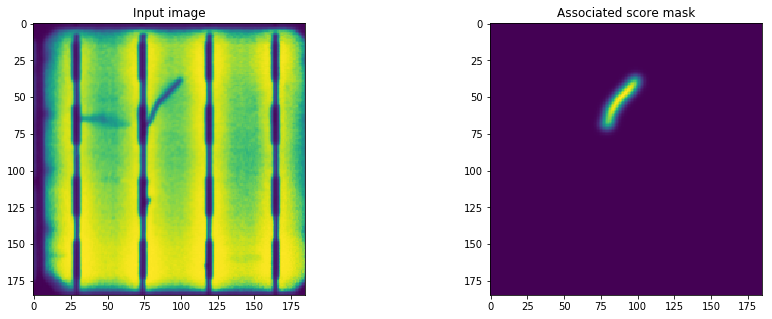

In [145]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(query_images[0, :, :, 0]); axs[0].set_title('Input image')
axs[1].imshow(query_scores[0, :, :, 0]); axs[1].set_title('Associated score mask');

### Define TensorFlow graph

In [152]:
class BatchNormalizedConvLayer(object):
    def __init__(self, map_size, in_channels, out_channels, activate=True):
        self.filters    = tf.Variable(tf.truncated_normal(
                                        shape = [map_size, map_size, in_channels, out_channels],
                                        stddev = 0.01))
        self.biases     = tf.Variable(tf.zeros(shape = [out_channels]))
        self.input_mean = tf.Variable(tf.zeros(shape = [out_channels]), trainable = False)
        self.input_var  = tf.Variable(tf.zeros(shape = [out_channels]), trainable = False)
        self.decay      = 0.999
        self.activate   = activate

    def training(self, data_in):
        self.conv        = tf.nn.conv2d(data_in, self.filters, strides = [1, 1, 1, 1],
                                       padding = 'SAME', use_cudnn_on_gpu = True)
        mu, var          = tf.nn.moments(self.conv, axes = [0, 1, 2], keep_dims = False)
        self.update_mean = tf.assign(self.input_mean, self.decay*(self.input_mean)
                                                      + (1 - self.decay)*mu)
        self.update_var  = tf.assign(self.input_var,  self.decay*(self.input_var)
                                                      + (1 - self.decay)*var)

        with tf.control_dependencies([self.update_mean, self.update_var]):
            self.norm_conv  = tf.nn.batch_normalization(self.conv, mean = mu,
                                                        variance = var, offset = None,
                                                        scale = None, variance_epsilon = 1e-5)
        if self.activate:
            return tf.nn.relu(self.norm_conv + self.biases)
        else:
            return self.norm_conv + self.biases

    def testing(self, data_in):
        self.conv       = tf.nn.conv2d(data_in, self.filters, strides = [1, 1, 1, 1],
                                       padding = 'SAME', use_cudnn_on_gpu = True)
        mu, var         = tf.nn.moments(self.conv, axes = [0, 1, 2], keep_dims = False)
        self.norm_conv  = tf.nn.batch_normalization(self.conv, mean = self.input_mean,
                                                    variance = self.input_var, offset = None,
                                                    scale = None, variance_epsilon = 1e-5)
        if self.activate:
            return tf.nn.relu(self.norm_conv + self.biases)
        else:
            return self.norm_conv + self.biases

In [180]:
TF = {
    'batch_size' : 32,
    'image_size' : 185,
    'filter_size' : [1, 3, 3, 3, 3],
    'in_channels' : 1,
    'out_channels' : [8, 8, 8, 8, 8],
    'learning_rate' : 0.01,
    'training_steps' : 10001,
    'summary_train' : [],
    'summary_test' : [],
    'model_id' : '009_ConvNetMaskPredictor'
}

In [181]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope('Inputs'):
        TF['data']   = tf.placeholder(tf.float32,
                                      shape = [None, TF['image_size'],
                                               TF['image_size'], TF['in_channels']])
        TF['scores'] = tf.placeholder(tf.float32,
                                      shape = [None, TF['image_size'],
                                               TF['image_size'], 2])
    
    with tf.name_scope('ConvolutionalLayers'):
        # First layer
        ConvLayer1 = BatchNormalizedConvLayer(TF['filter_size'][0], TF['in_channels'],
                                              TF['out_channels'][0], activate = True)
        # Second layer
        ConvLayer2 = BatchNormalizedConvLayer(TF['filter_size'][1], TF['out_channels'][0],
                                              TF['out_channels'][1], activate = True)
        # Third layer
        ConvLayer3 = BatchNormalizedConvLayer(TF['filter_size'][2], TF['out_channels'][1],
                                              TF['out_channels'][2], activate = True)
        # Fourth layer
        ConvLayer4 = BatchNormalizedConvLayer(TF['filter_size'][3], TF['out_channels'][2],
                                              TF['out_channels'][3], activate = True)
        # Fifth layer
        ConvLayer5 = BatchNormalizedConvLayer(TF['filter_size'][4], TF['out_channels'][3],
                                              TF['out_channels'][4], activate = True)
        # Perform 2 1x1 convolutions (no nonlinearity) to produce a 2-channel image
        ConvLayer6 = BatchNormalizedConvLayer(1, TF['out_channels'][4],
                                              2, activate = False)
    
    def training_model(data):
        activation1 = ConvLayer1.training(data)
        activation2 = ConvLayer2.training(activation1)
        activation3 = ConvLayer3.training(activation2)
        activation4 = ConvLayer4.training(activation3)
        activation5 = ConvLayer5.training(activation4)
        logits = ConvLayer6.training(activation5)
        return logits
        
    def testing_model(data):
        activation1 = ConvLayer1.testing(data)
        activation2 = ConvLayer2.testing(activation1)
        activation3 = ConvLayer3.testing(activation2)
        activation4 = ConvLayer4.testing(activation3)
        activation5 = ConvLayer5.testing(activation4)
        logits      = ConvLayer6.testing(activation5)
        return logits
    
    with tf.name_scope('Training'):
        logits                     = training_model(TF['data'])
        activated                  = tf.nn.softmax(logits, dim = -1)
        TF['training_predictions'] = tf.slice(activated, [0, 0, 0, 0], [-1, -1, -1, 1])
        ohe_logits                 = tf.reshape(logits, [-1, 2])
        ohe_scores                 = tf.reshape(TF['scores'], [-1, 2])
        TF['training_loss']        = tf.reduce_mean(
                                        tf.nn.softmax_cross_entropy_with_logits(
                                            labels = ohe_scores, logits = ohe_logits))
        TF['summary_train'].append(tf.summary.scalar('CrossEntropy', TF['training_loss']))
        
        with tf.name_scope('Gradients'):
            optimizer      = tf.train.GradientDescentOptimizer(TF['learning_rate'])
            vars_to_update = [ConvLayer1.filters, ConvLayer2.filters, ConvLayer3.filters,
                              ConvLayer1.biases, ConvLayer2.biases, ConvLayer3.biases]
            gradients      = optimizer.compute_gradients(TF['training_loss'], vars_to_update)
            TF['optimize'] = optimizer.apply_gradients(gradients)
        
        TF['summary_train'].append(tf.summary.image('Query', TF['data']))
        TF['summary_train'].append(tf.summary.image('Masks',
                                                    tf.slice(TF['scores'], [0, 0, 0, 0], [-1, -1, -1, 1])))
        TF['summary_train'].append(tf.summary.image('Predictions', TF['training_predictions']))
        
    with tf.name_scope('Testing'):
        logits    = testing_model(TF['data'])
        activated = tf.nn.softmax(logits, dim = -1)
        TF['testing_predictions'] = tf.slice(activated, [0, 0, 0, 0], [-1, -1, -1, 1])
        ohe_logits                = tf.reshape(logits, [-1, 2])
        ohe_scores                = tf.reshape(TF['scores'], [-1, 2])
        TF['testing_loss']        = tf.reduce_mean(
                                        tf.nn.softmax_cross_entropy_with_logits(
                                            labels = ohe_scores, logits = ohe_logits))

        TF['summary_test'].append(tf.summary.image('Query', TF['data']))
        TF['summary_test'].append(tf.summary.image('Masks', 
                                                   tf.slice(TF['scores'], [0, 0, 0, 0], [-1, -1, -1, 1])))
        TF['summary_test'].append(tf.summary.image('Predictions', TF['testing_predictions']))
        TF['summary_test'].append(tf.summary.scalar('Loss', TF['testing_loss']))
        
    TF['saver'] = tf.train.Saver()
    TF['train_summary'] = tf.summary.merge(TF['summary_train'])
    TF['test_summary']  = tf.summary.merge(TF['summary_test'])

### Instantiate and train the model

In [182]:
def augment_images(images, scores):
    """
        Applies augmentations to a minibatch.
        > Flips
        > Whitens
    """
    # Flip images lr
    flip_lr = np.random.randint(0, 2, images.shape[0])
    images[flip_lr, :, :, :] = np.flip(images[flip_lr, :, :, :], axis = 2)
    scores[flip_lr, :, :, :] = np.flip(scores[flip_lr, :, :, :], axis = 2)
    
    # Flip images ud
    flip_ud = np.random.randint(0, 2, images.shape[0])
    images[flip_ud, :, :, :] = np.flip(images[flip_ud, :, :, :], axis = 1)
    scores[flip_ud, :, :, :] = np.flip(scores[flip_ud, :, :, :], axis = 1)
    
    # Whiten across minibatch; this has a regularizing effect
    images = (images - np.mean(images, axis = 0))/images.std(axis = 0)
    
    return images, scores

In [183]:
def get_minibatch(batch_size, images, scores, labels):
    """
        Returns a balanced and augmented subset of the images and scores passed.
    
        Labels is a binary mask indicating which images contain cracks
        Images is a stack of images, ordered in the same sequence as scores
        Scores is a stack of np.float32 masks of crack scores, ordered in the same sequence as images
    """
    ix = {
          'cracked'   : np.array(np.nonzero(labels)).squeeze(),
          'uncracked' : np.array(np.nonzero(np.logical_not(labels))).squeeze()
         }
    ix['cracked']    = np.random.choice(ix['cracked'],
                                     size = batch_size // 2, replace = True)
    ix['uncracked']  = np.random.choice(ix['uncracked'],
                                       size = batch_size // 2, replace = True)
    ix               = list(ix['cracked']) + list(ix['uncracked'])

    minibatch_images, minibatch_scores = augment_images(images[ix, :, :, :],
                                                        scores[ix, :, :, :])
    return minibatch_images, minibatch_scores

In [184]:
with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    train_writer = tf.summary.FileWriter('./Results/' + TF['model_id'] + '/train', session.graph)
    test_writer  = tf.summary.FileWriter('./Results/' + TF['model_id'] + '/test', session.graph)
    
    for step in range(TF['training_steps']):
        minibatch_images, minibatch_scores = get_minibatch(TF['batch_size'],
                                                           images, scores, labels)
        fd = { TF['data']   : minibatch_images,
               TF['scores'] : minibatch_scores }
        _, l, s = session.run([TF['optimize'], TF['training_loss'],
                               TF['train_summary']], feed_dict = fd)
        train_writer.add_summary(s, step)
        
        if step % 100 == 0:
            print('Mean minibatch cross-entropy @ step {:^5d}: {:>3.3f}'.format(step, l))

        if step % 500 == 0:
            fd   = { TF['data']   : query_images,
                     TF['scores'] : query_scores }
            s = session.run(TF['test_summary'], feed_dict = fd)
            test_writer.add_summary(s, step)
            
    TF['saver'].save(session, TF['model_id'])

Minibatch RSS @ step 0: 461.84375
Minibatch RSS @ step 100: 492.30322265625
Minibatch RSS @ step 200: 436.9056091308594
Minibatch RSS @ step 300: 398.4895324707031
Minibatch RSS @ step 400: 552.5054931640625
Minibatch RSS @ step 500: 400.3674621582031
Minibatch RSS @ step 600: 456.04864501953125
Minibatch RSS @ step 700: 468.30987548828125
Minibatch RSS @ step 800: 556.0706176757812
Minibatch RSS @ step 900: 477.3418884277344
Minibatch RSS @ step 1000: 529.5509033203125
Minibatch RSS @ step 1100: 504.89404296875
Minibatch RSS @ step 1200: 423.79144287109375
Minibatch RSS @ step 1300: 441.7582092285156
Minibatch RSS @ step 1400: 509.7647399902344
Minibatch RSS @ step 1500: 501.65869140625
Minibatch RSS @ step 1600: 484.80230712890625
Minibatch RSS @ step 1700: 497.47259521484375
Minibatch RSS @ step 1800: 537.4412841796875
Minibatch RSS @ step 1900: 476.6666564941406
Minibatch RSS @ step 2000: 496.7810974121094
Minibatch RSS @ step 2100: 460.8757019042969
Minibatch RSS @ step 2200: 436.